In [11]:
from src.constants import fn_osm_db_dc
fn_osm_db_dc

'osm_db_dc.sqlite3'

In [44]:
osm_db_dc = 'data/'+fn_osm_db_dc

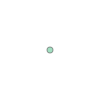

In [45]:
import sqlite3
from src.osm.osm2db import create_connection, TB_GEOM, TB_MMBR, TB_TAG
from shapely.wkb import loads as load_wkb_str
def get_geom_by_otoid(osm_db,ot,oid):
    sql = "SELECT * FROM {tb} WHERE ot='{ot}' AND oid={oid}".format(tb=TB_GEOM, ot=ot, oid=oid)
    with create_connection(osm_db) as conn:
        conn.text_factory = str
        cursor = conn.cursor()
        cursor.execute(sql)
        rows = cursor.fetchall()
    assert len(rows)<=1, 'fetch data by ot={} oid={} with more than one row'.format(ot, oid)
    if len(rows)==1: return load_wkb_str(rows[0][2])
    print 'no geometry match ot={}, oid={} in db: {}'.format(ot, oid, osm_db)
    return None

geom = get_geom_by_otoid(osm_db_dc, 'N',30066952)
geom 

In [103]:
def exec_sql(osm_db, sql):
    with create_connection(osm_db) as conn:
        cursor = conn.cursor()
        cursor.execute(sql)
        rows = cursor.fetchall()
    return rows

In [148]:
def filter_tbtag(osm_db, in_tags=((None,None),), ex_tags=((None,None),), ot=None):
    sql = "SELECT * FROM {tb}".format(tb=TB_TAG) # tag=(*,*), any objs with any tag
    assert isinstance(in_tags[0],tuple) or isinstance(in_tags[0],list), 'elements of tags should be tuple or list, tags={}'.format(in_tags)
    assert isinstance(ex_tags[0],tuple) or isinstance(ex_tags[0],list), 'elements of ex_tags should be tuple or list, tags={}'.format(ex_tags)
    
    def build_clause(tags):
        clause = []
        for key, value in tags:
            if key:
                if value==None:  # tag:some_k=*
                    clause.append("key='{}'".format(key))
                elif not isinstance(value, list) and not isinstance(value, tuple):  # tag:some_k=some_v
                    clause.append("key='{}' and value='{}'".format(key, value))
                else:
                    v_clause = ' or '.join(["value='{}'".format(v) for v in value])
                    clause.append("key='{}' and ({})".format(key, v_clause))    
        return clause
    
    in_tags_clause = build_clause(in_tags)
    ex_tags_clause = build_clause(ex_tags)

    where_clause = []
    if ot: where_clause.append("ot='{}'".format(ot))
    if in_tags_clause: where_clause.append('(' + ') or ('.join(in_tags_clause) + ')')
    if ex_tags_clause: where_clause.append('not((' + ') or ('.join(ex_tags_clause) + '))')
    where_clause = ') AND ('.join(where_clause)
    sql = '{sql} WHERE ({where})'.format(sql=sql, where=where_clause) if where_clause else sql

    print sql
    rows = exec_sql(osm_db, sql)
    df = pd.DataFrame(rows, columns=['ot','oid','key','value'])
    print '# rows', len(rows)
    print 'ot:', pd.unique(df.ot)
    if len(pd.unique(df.key))<3:
        print 'keys:',pd.unique(df.key)
        for key in pd.unique(df.key):
            print 'key =',key, 'value:', pd.unique(df[df.key==key].value)
    print '==========================='
    print 


In [149]:

# Test cases
filter_tbtag(osm_db_dc)  # no where clause
filter_tbtag(osm_db_dc, ot='N')  # only where ot=ot
filter_tbtag(osm_db_dc, in_tags=(('highway', None ),))  # only in_tags, has key
filter_tbtag(osm_db_dc, in_tags=(('highway', None ),), ot='N')  # ot + in_tags(has key)
filter_tbtag(osm_db_dc, in_tags=(('highway', 'stop' ),), ot='N')  # ot + in_tags(some_k=some_v)

filter_tbtag(osm_db_dc, in_tags=(('highway', ('stop','traffic_signals','crossing')),), ot='N')  # ot + in_tags(multiple values of some_k)
filter_tbtag(osm_db_dc, in_tags=(('traffic_signals', 'signal'),), ot='N')  # for comparision of whether multiple keys works as expected
filter_tbtag(osm_db_dc, in_tags=(('highway', ('stop','traffic_signals','crossing')),('traffic_signals', 'signal')), ot='N')  # ot + in_tags(multiple keys, multiple values for one key)

filter_tbtag(osm_db_dc, in_tags=(('highway', ('stop','traffic_signals','crossing')),('traffic_signals', 'signal')), ex_tags=(('highway','stop'),), ot='N')  # ot + in_tags + ex_tags(some_k=some_v)
filter_tbtag(osm_db_dc, in_tags=(('highway','stop'),), ot='N')  # for comparision of whether ex_tags(some_k=some_v) works as expected

filter_tbtag(osm_db_dc, in_tags=(('highway', ('stop','traffic_signals','crossing')),('traffic_signals', 'signal')), ex_tags=(('highway',['stop','crossing']),), ot='N')  # ot + in_tags + ex_tags(multiple values of some_k)
filter_tbtag(osm_db_dc, in_tags=(('highway',['stop','crossing']),), ot='N')  # for comparision of whether ex_tags(multiple values of some_k) works as expected

filter_tbtag(osm_db_dc, in_tags=(('highway', ('stop','traffic_signals','crossing')),('traffic_signals', ['signal','crossing'])), ot='N')  # for comparision
filter_tbtag(osm_db_dc, in_tags=(('highway', ('stop','traffic_signals','crossing')),('traffic_signals', ['signal','crossing'])), ex_tags=(('highway',['stop','crossing']),('traffic_signals','signal')), ot='N')  # ot+in_tags+ex_tags(multiple keys and multiple values)
filter_tbtag(osm_db_dc, in_tags=(('highway',['stop','crossing']),('traffic_signals','signal')), ot='N')  # for comparision

SELECT * FROM tag
# rows 1484405
ot: [u'N' u'W' u'R']

SELECT * FROM tag WHERE (ot='N')
# rows 157884
ot: [u'N']

SELECT * FROM tag WHERE ((key='highway'))
# rows 23232
ot: [u'N' u'W' u'R']
keys: [u'highway']
key = highway value: [u'stop' u'crossing' u'traffic_signals' u'give_way' u'motorway_junction'
 u'turning_circle' u'mini_roundabout' u'turning_loop' u'speed_camera'
 u'bus_stop' u'emergency_access_point' u'elevator' u'milestone'
 u'residential' u'footway' u'secondary' u'primary_link' u'tertiary'
 u'primary' u'trunk' u'unclassified' u'motorway' u'trunk_link'
 u'motorway_link' u'service' u'secondary_link' u'tertiary_link' u'path'
 u'pedestrian' u'cycleway' u'steps' u'construction' u'track' u'services'
 u'yes' u'living_street' u'bridleway']

SELECT * FROM tag WHERE (ot='N') AND ((key='highway'))
# rows 4703
ot: [u'N']
keys: [u'highway']
key = highway value: [u'stop' u'crossing' u'traffic_signals' u'give_way' u'motorway_junction'
 u'turning_circle' u'mini_roundabout' u'turning_loop' u'

In [4]:
%load_ext sql

In [7]:
%sql sqlite:///data/osm_db_dc.sqlite3

u'Connected: None@data/osm_db_dc.sqlite3'

In [23]:
%%sql
SELECT ot, oid FROM geometry WHERE ot='N' AND oid=30066952

Done.


ot,oid
N,30066952


In [136]:
result = %sql SELECT DISTINCT * FROM tag WHERE (ot='N') AND ((key='traffic_signals'))
df = result.DataFrame()
df.sort('oid').head(10)

Done.


,ot,oid,key,value
0,N,49716545,traffic_signals,signal
1,N,49716602,traffic_signals,signal
2,N,49716610,traffic_signals,signal
3,N,49718775,traffic_signals,signal
4,N,49718816,traffic_signals,signal
5,N,49723816,traffic_signals,signal
6,N,49724285,traffic_signals,signal
7,N,49730831,traffic_signals,signal
8,N,49731188,traffic_signals,signal
9,N,49731194,traffic_signals,signal


In [101]:
result = %sql SELECT DISTINCT * FROM tag WHERE (ot='N') AND ((key='highway' and (value='stop' or value='traffic_signals')) or (key='traffic_signals' and value='signal'))
df = result.DataFrame()
df.sort('oid').head(10)

Done.


,ot,oid,key,value
0,N,49715946,highway,stop
1,N,49715951,highway,stop
2,N,49715974,highway,stop
3,N,49716545,highway,traffic_signals
4,N,49716545,traffic_signals,signal
5,N,49716602,highway,traffic_signals
6,N,49716602,traffic_signals,signal
7,N,49716610,highway,traffic_signals
8,N,49716610,traffic_signals,signal
9,N,49716662,highway,traffic_signals


In [137]:
print pd.unique(df.ot)
print pd.unique(df.key)
print pd.unique(df[df.key=='highway'].value)
print pd.unique(df[df.key=='traffic_signals'].value)

[u'N']
[u'traffic_signals']
[]
[u'signal' u'crossing']


In [94]:
result = %sql SELECT DISTINCT * FROM tag WHERE ((key='highway'))

df = result.DataFrame()

df.head(10)

Done.


,ot,oid,key,value
0,N,49715946,highway,stop
1,N,49715951,highway,stop
2,N,49715974,highway,stop
3,N,49716326,highway,crossing
4,N,49716545,highway,traffic_signals
5,N,49716602,highway,traffic_signals
6,N,49716610,highway,traffic_signals
7,N,49716662,highway,traffic_signals
8,N,49716664,highway,crossing
9,N,49716680,highway,traffic_signals


In [81]:
result = %sql select * from tag limit 10000

df = result.DataFrame()

df.head(10)

Done.


,ot,oid,key,value
0,N,30066952,created_by,JOSM
1,N,30066953,created_by,JOSM
2,N,30066954,created_by,JOSM
3,N,30066955,created_by,JOSM
4,N,49715946,highway,stop
5,N,49715951,highway,stop
6,N,49715974,highway,stop
7,N,49716326,highway,crossing
8,N,49716545,traffic_signals,signal
9,N,49716545,highway,traffic_signals
